In [0]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dense(1, activation='linear', kernel_initializer=init))
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

In [0]:
# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 256 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Reshape((7, 7, 256)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# upsample to 28x28
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), padding='same', kernel_initializer=init))
	model.add(Activation('tanh'))
	return model

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

In [4]:
# example of lsgan for mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dense(1, activation='linear', kernel_initializer=init))
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 256 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Reshape((7, 7, 256)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# upsample to 28x28
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), padding='same', kernel_initializer=init))
	model.add(Activation('tanh'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

# load mnist images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# # select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('Saved %s and %s' % (filename1, filename2))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	pyplot.plot(d1_hist, label='dloss1')
	pyplot.plot(d2_hist, label='dloss2')
	pyplot.plot(g_hist, label='gloss')
	pyplot.legend()
	filename = 'plot_line_plot_loss.png'
	pyplot.savefig(filename)
	pyplot.close()
	print('Saved %s' % (filename))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for storing loss, for plotting later
	d1_hist, d2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# prepare real and fake samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update the generator via the discriminator's error
		z_input = generate_latent_points(latent_dim, n_batch)
		y_real2 = ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(z_input, y_real2)
		# summarize loss on this batch
		#print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))
		# record history
		d1_hist.append(d_loss1)
		d2_hist.append(d_loss2)
		g_hist.append(g_loss)
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, latent_dim)
	# create line plot of training history
	plot_history(d1_hist, d2_hist, g_hist)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Using TensorFlow backend.









11493376/11490434 [==============================] - 2s 0us/step
(60000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Saved generated_plot_000937.png and model_000937.h5
Saved generated_plot_001874.png and model_001874.h5
Saved generated_plot_002811.png and model_002811.h5
Saved generated_plot_003748.png and model_003748.h5
Saved generated_plot_004685.png and model_004685.h5
Saved generated_plot_005622.png and model_005622.h5
Saved generated_plot_006559.png and model_006559.h5
Saved generated_plot_007496.png and model_007496.h5
Saved generated_plot_008433.png and model_008433.h5
Saved generated_plot_009370.png and model_009370.h5
Saved generated_plot_010307.png and model_010307.h5
Saved generated_plot_011244.png and model_011244.h5
Saved generated_plot_012181.png and model_012181.h5
Saved generated_plot_013118.png and model_013118.h5
Saved generated_plot_014055.png and model_014055.h5
Saved generated_plot_014992.png and model_014992.h5
Saved generated_plot_015929.png and model_015929.h5
Saved generated_plot_016866.png and model_016866.h5
Saved generated_plot_017803.png and model_017803.h5
Saved genera

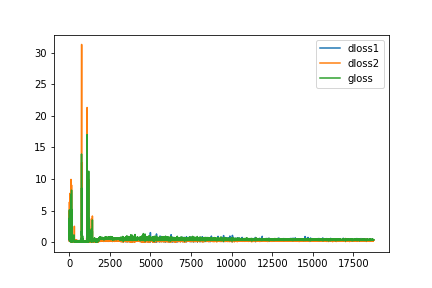

In [6]:
from IPython.display import Image
Image('plot_line_plot_loss.png')

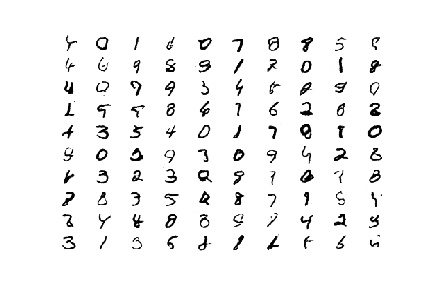

In [7]:
from IPython.display import Image
Image('generated_plot_018740.png')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


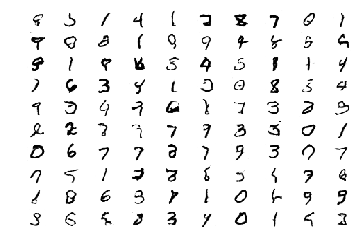

In [5]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create a plot of generated images (reversed grayscale)
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('model_018740.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
plot_generated(X, 10)